# Ch `08`: Concept `01`

## Reinforcement learning

출처 : http://www.tensorflowbook.com/
요약 :  송영숙

<img src="01.png" width="500"><BR>

<img src="02.png" width="500"><BR>

**Reinforcement** learning is about making the right **actions**, given any **state**

The **states** are previous history of stock prices, current budget, and current number of shares of a stock.

The **actions** are buy, sell, or hold (i.e. do nothing).

The stock market data comes from the Yahoo Finance library, `pip install yahoo-finance`.

교통체증의 한복판에 있을 때 목적지에 도달하기 위한 우리의 판단은 강화학습으로 문제를 푸는 방법과 비슷하다.

<img src="03.png" width="500"><BR>

동작은 화살표로 표시되고 상태는 원으로 표시된다.

현재 stste에서  action을 수행하면 보상을 얻는다. 

상태 s1에서 시작하면 a1 액션을 수행하여 보상 r (s1, a1)을 얻을 수 있다.

로봇은 state를 변경하는 action을 수행하기 위한 동작을 어떻게 결정할까?
이 질문에 대답하기위한 Policy라는 개념이 필요하다.


<img src="04.png" width="500"><BR>

<img src="05.png" width="500"><BR>

**보상**은 행동을 취한 결과의 척도이다.

**최적의 보상**: 좋은 정책을 발견하는 것이 정책의 가장 큰 기능이고 장기적인 결과를 관찰하는 것이 가장 좋은 정책을 만드는 방법이다. 최적의 정책은 어떤 상태에서도 최적의 조치를 알려주지만 현재로서는 가장 높은 보상을 제공하지 않을 수 있다.

**즉각적 보상(greedy strategy)** : 인 결과를 보면서 보상을 측정한다면 행동을 취한 후에는 계산하기 쉽다. 

그러나 최선의 즉각적인 행동을 "탐욕스럽게” 선택하는 것이 항상 좋은 생각은 아니다.



# Applying reinforcement learning

사고 팔고 유지하는 세가지 기본적인 패턴만 생각해보자.

• 현재 주가로 주식을 사면 현재 주식 수를 증가하지만 예산은 줄어든다.

• 주식 판매는 현재 주가로 돈을 번게 된다.

• 보류는 단기간에 보상을 제공하지 않는다.

<img src="Opening_stock_prices.png" width="500"><BR>

이상적인 것은 최저인 기간에 사서 최고인 기간에 팔는 것으로 160$의 이익을 얻게 된다. 

그에 비해 high-frequency trading을 하면 그림에서 볼 수 있듯이 단기에 이익을 내기 위해 자주 사고 팔게 된다. 

# Implementing reinforcement learning

In [25]:
%matplotlib inline
from yahoo_finance import Share #주식 로우 데이터 가져오기
from matplotlib import pyplot as plt #주가를 플롯으로 그려주기 위해서
import numpy as np #숫자 처리
import random
import tensorflow as tf #머신러닝


# Defining a superclass for all decision policies

Define an abstract class called `DecisionPolicy`:

In [26]:
class DecisionPolicy:
    def select_action(self, current_state, step): #지금 상태에서 다음 행동을 선택할 수 있도록 정책 결정
        pass

    def update_q(self, state, action, reward, next_state): #다음 단계의 action으로 나아가기 위한 Q-function
        pass

<img src="sras.png" width="500"><BR>

 best action (a), given a state (s),  reward (r) , the newly acquired knowledge (s, r, a, s')

Here's one way we could implement the decision policy, called a random decision policy:

# Implementing a random decision policy

In [27]:
class RandomDecisionPolicy(DecisionPolicy): #DecisionPolicy에서 상속 받은 함수를 구현한다
    def __init__(self, actions):
        self.actions = actions

    def select_action(self, current_state, step): #다음 action을 랜덤으로 선택한다.
        action = random.choice(self.actions)
        return action

<img src="07.png" width="500"><BR>

특정 크기의 rolling window는 주식 가격을 S1, S2 및 S3 상태로 구분 된 차트로 표시하게 된다. 

policy는 공격이나 무작위 탐색 등의 다음에 취할 행동을 제안한다.

action에 대한 보상을 받으면 시간이 지남에 따라 policy function을 갱신 할 수 있다.

That's a good baseline. Now let's use a smarter approach using a neural network:

이제 결과를 비교할 기준선을 얻었으므로 신경망 접근법을 구현하여 Q 기능을 학습하려고 한다.

의사 결정 정책은 흔히 Q-learning 의사 결정 정책이라고 한다.


새로운 액션 매개 변수인 엡실론 (itpsilon)을 사용하여 동일한 액션을 반복해서 적용하면서 솔루션이 멈추지 않도록 한다. 

그 값이 낮을수록, 더 자주 무작위 탐색을 한다

<img src="08.png" width="500"><BR>

벡터 스페이스 상태의 인풋과 각각의 Q-value 아웃풋을 위한 세 아웃풋

# Implementing a more intelligent decision policy

In [28]:
class QLearningDecisionPolicy(DecisionPolicy): #Q-function으로부터 hyperparameters 세팅
    def __init__(self, actions, input_dim):
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 20  #Q-function의 히든 노드 개수

        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim]) #인풋과 아웃풋 텐서 정의
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim])) #뉴럴 네티워크 아키텍쳐 디자인
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)   #utility를 계산하기 위한 q 정의

        loss = tf.square(self.y - self.q) #square error 로스 세팅
        self.train_op = tf.train.AdamOptimizer(0.001).minimize(loss) 
        #로스를 최소화하기 위한 모델 파라메터 업데이트를 위한 옵티마이저
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            # Exploit best option with probability epsilon
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)  # TODO: replace w/ tensorflow's argmax
            action = self.actions[action_idx]
        else:
            # Explore random option with probability 1 - epsilon
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})

Define a function to run a simulation of buying and selling stocks from a market:

# Running multiple simulations to calculate an average performance

In [29]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, debug=False):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:  
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)

    portfolio = budget + num_stocks * share_value
    if debug:
        print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio

We want to run simulations multiple times and average out the performances:

In [30]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 5
    final_portfolios = list()
    for i in range(num_tries):
        print('Running simulation {}...'.format(i + 1))
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
    plt.title('Final Portfolio Value')
    plt.xlabel('Simulation #')
    plt.ylabel('Net worth')
    plt.plot(final_portfolios)
    plt.show()

# Helper function to get prices

Call the following function to use the Yahoo Finance library and obtain useful stockmarket data. 

In [31]:
def get_prices(share_symbol, start_date, end_date, cache_filename='stock_prices.npy'):
    try:
        stock_prices = np.load(cache_filename)  #데이터 로딩
    except IOError:
        share = Share(share_symbol)  #Library로부터 stock prices 추출
        stock_hist = share.get_historical(start_date, end_date)
        stock_prices = [stock_price['Open'] for stock_price in stock_hist]
        np.save(cache_filename, stock_prices) #결과를 케시

    return stock_prices.astype(float)

# Helper function to plot the stock prices

Who wants to deal with stock market data without looking a pretty plots? No one. So we need this out of law:

In [32]:
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')
    plt.show()

# Get data and visualize it

Train a reinforcement learning policy:

아래의 첫번째 차트는 1992 년 7 월 22 일부터 2016 년 7 월 22 일까지 Microsoft (MSFT)의 개시 주가를 요약 한 것이다. 3000 일 전후에 사서 싶지 않은가? 약 5000 일 전후에 팔고 싶지 않은가?

우리가 코드로 구매, 판매 및 보유를 통해 최적의 이익을 얻을 수 있는지 알아 봅자.

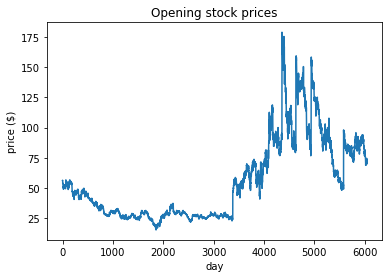

Running simulation 1...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $208790.17000200003
Running simulation 2...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $220215.7124400001
Running simulation 3...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $218831.20998900014
Running simulation 4...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $219273.09936400029
Running simulation 5...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $219441.67312500018


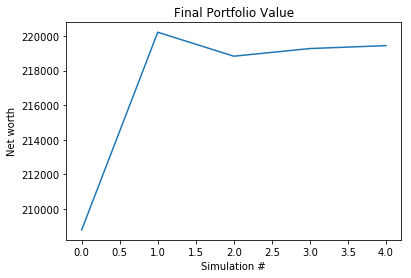

In [33]:
if __name__ == '__main__':
    prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
    plot_prices(prices)
    actions = ['Buy', 'Sell', 'Hold']
    hist = 3
    # policy = RandomDecisionPolicy(actions)
    policy = QLearningDecisionPolicy(actions, hist + 2) #QLearning을 통한 상태 업데이트
    budget = 100000.0
    num_stocks = 0
    run_simulations(policy, budget, num_stocks, prices, hist)

<img src="tk.png" width="500"><BR>

감사합니다.